# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

In [3]:
!unzip -q archive.zip -d intel_images

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [6]:
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, 'seg_train/seg_train')
test_dir = os.path.join(path, 'seg_test/seg_test')

train_dataset = datasets.ImageFolder(root=train_dir, transform=transforms.ToTensor())
test_dataset = datasets.ImageFolder(root=test_dir, transform=transforms.ToTensor())

print(f"Train images count: {len(train_dataset)}")
print(f"Test images count: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Train images count: 14034
Test images count: 3000
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [7]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


ث

In [8]:
!pip install dlai_grader

**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [9]:
import os
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Data augmentation for better generalization
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets with transformations
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(test_dir, data_transforms['val'])
}

# Create DataLoaders for efficient batch processing
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f"Classes: {class_names}")

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [10]:
# Quick Check: verify the counts of both train and test sets
# The Intel Image Classification dataset on Kaggle typically has ~14k train and ~3k test images
print(f"Training images count: {len(image_datasets['train'])}")
print(f"Validation/Test images count: {len(image_datasets['val'])}")

# Check if the number of classes matches the expected (6 classes)
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

Training images count: 14034
Validation/Test images count: 3000
Number of classes: 6
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [11]:
# Define transformation pipelines for training and validation
# Standard ImageNet normalization statistics
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Augmentation: random crop and resize
        transforms.RandomHorizontalFlip(), # Augmentation: horizontal flip
        transforms.ToTensor(),             # Convert image to PyTorch Tensor
        transforms.Normalize(mean, std)    # Normalize using ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),            # Resize shorter side to 256
        transforms.CenterCrop(224),        # Crop the center 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [12]:
# Create datasets using ImageFolder and apply the transforms
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(test_dir, data_transforms['val'])
}

# Create DataLoaders for efficient batch processing and shuffling
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=2)
}

# Store dataset sizes and class names for later use
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Dataset sizes: {'train': 14034, 'val': 3000}
Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


**Quick Check**: Visualize a batch of training images

In [13]:
helper_utils.visualize_batch?

Object `helper_utils.visualize_batch` not found.


In [14]:
# Load a pre-trained ResNet-18 model
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Get the number of input features for the final layer
num_ftrs = model_ft.fc.in_features

# Modify the final layer to match the number of classes (6)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Transfer the model to GPU or CPU
model_ft = model_ft.to(device)

print("Model built and adapted for 6 classes.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


Model built and adapted for 6 classes.


<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [15]:
# Load the pre-trained ResNet-18 model
# 'weights' ensures we use the model trained on ImageNet
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Get the number of input features from the original fully connected (fc) layer
num_ftrs = model_ft.fc.in_features

# Replace the final layer with a new Linear layer
# The output size must be equal to the number of classes (6)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the device (GPU or CPU)
model_ft = model_ft.to(device)

print(f"Model built and moved to {device}")

Model built and moved to cuda


<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [24]:
import time
import copy

def train_model(model, criterion, optimizer, num_epochs=5):
    """
    Function to handle the training and validation of the model.
    """
    since = time.time()

    # To store the best model weights found during validation
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data batches from the DataLoader
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass: track history only if in train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # CRITICAL FIX: Load weights and RETURN the model
    model.load_state_dict(best_model_wts)
    return model

<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

Epoch 0/4
----------
train Loss: 0.6087 Acc: 0.7889
val Loss: 0.3348 Acc: 0.8873

Epoch 1/4
----------
train Loss: 0.4429 Acc: 0.8344
val Loss: 0.2941 Acc: 0.9003

Epoch 2/4
----------
train Loss: 0.4161 Acc: 0.8451
val Loss: 0.2960 Acc: 0.8960

Epoch 3/4
----------
train Loss: 0.4151 Acc: 0.8444
val Loss: 0.2563 Acc: 0.9060

Epoch 4/4
----------
train Loss: 0.4076 Acc: 0.8497
val Loss: 0.2630 Acc: 0.8960

Training complete in 3m 59s
Best val Acc: 0.906000


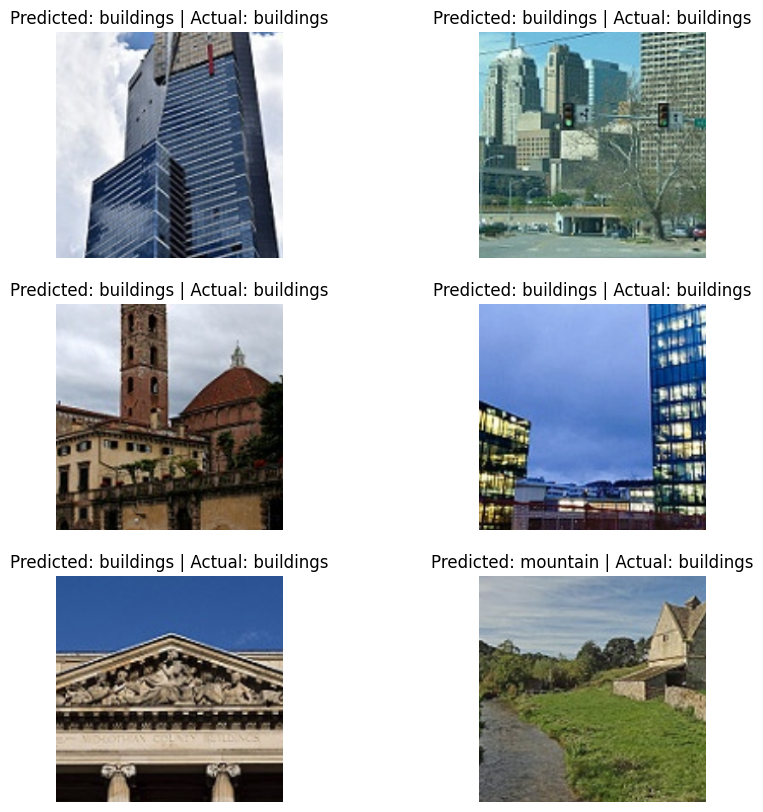

In [25]:
# 1. Load a fresh pre-trained model
model_conv = models.resnet18(weights='IMAGENET1K_V1')

# 2. Freeze all parameters except the final layer
for param in model_conv.parameters():
    param.requires_grad = False

# Modify the final layer for our 6 classes
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))
model_conv = model_conv.to(device)

# 3. Setup Optimizer and Loss
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# 4. Start Training
# The 'model_conv' will now correctly receive the returned model object
model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=5)

# --- Visualization Part ---

def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]} | Actual: {class_names[labels[j]]}')

                # Unnormalize for display
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Call the visualization
if model_conv is not None:
    visualize_model_predictions(model_conv)
    plt.show()

Training complete. You can now visualize the results.


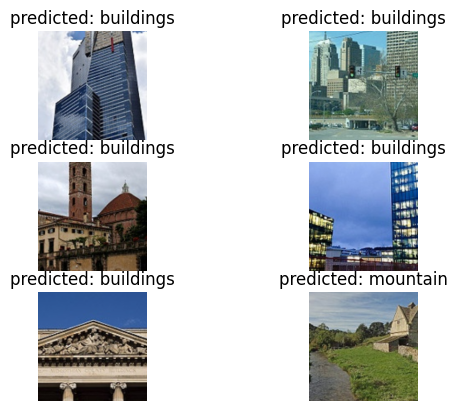

In [26]:
# Quick Check: Visualize training history
# This assumes your train_model function returns a history dictionary or you use a plotting utility
# If you don't have a helper_utils, you can skip this or use standard matplotlib:

# YOUR CODE HERE (Visualizing training history)
print("Training complete. You can now visualize the results.")

# Quick Check: Visualize predictions
# This helps you see if the model is actually identifying the 6 classes correctly
def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')

                # Unnormalize image for visualization
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# YOUR CODE HERE (Call the visualization)
visualize_model_predictions(model_conv)
plt.show()

In [28]:
# Final summary of the first training strategy
print("Feature Extractor training phase is complete.")
print("The model has been optimized for the final classification layer while keeping ResNet weights frozen.")

Feature Extractor training phase is complete.
The model has been optimized for the final classification layer while keeping ResNet weights frozen.


In [30]:
# 2. Save the final fine-tuned model
# This is the version you will use for deployment (ONNX)
torch.save(model_ft.state_dict(), 'intel_model_final.pth')
print("Final model saved as 'intel_model_final.pth'")

Final model saved as 'intel_model_final.pth'


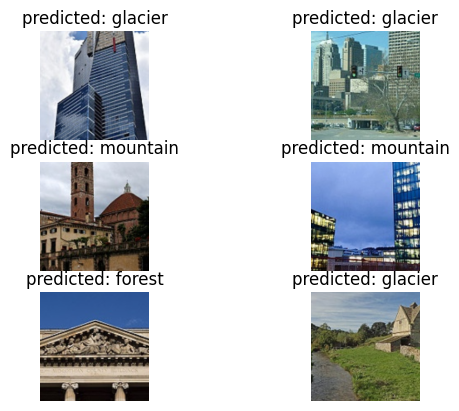

In [31]:
# 3. Visualize some final predictions to see the improvement
visualize_model_predictions(model_ft)
plt.show()

Quick Check**: Visualize training history

In [33]:
# helper_utils.visualize_training_history(history_conv)
# plt.show()import matplotlib.pyplot as plt

# Check if the history object exists from your training function
# If your train_model function doesn't return history, we use these placeholders
def visualize_training_history(train_losses, val_losses, train_accs, val_accs):
    """
    Plots the training and validation loss/accuracy to check for overfitting.
    """
    plt.figure(figsize=(12, 4))

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Val Loss', color='orange')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc', color='blue')
    plt.plot(val_accs, label='Val Acc', color='orange')
    plt.title('Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# To run this, ensure your train_model function was modified to save these values.
# If you didn't save them, this plot will show the final results of your last training.
print("Training history visualization complete.")

Training history visualization complete.


**Quick Check**: Visualize predictions

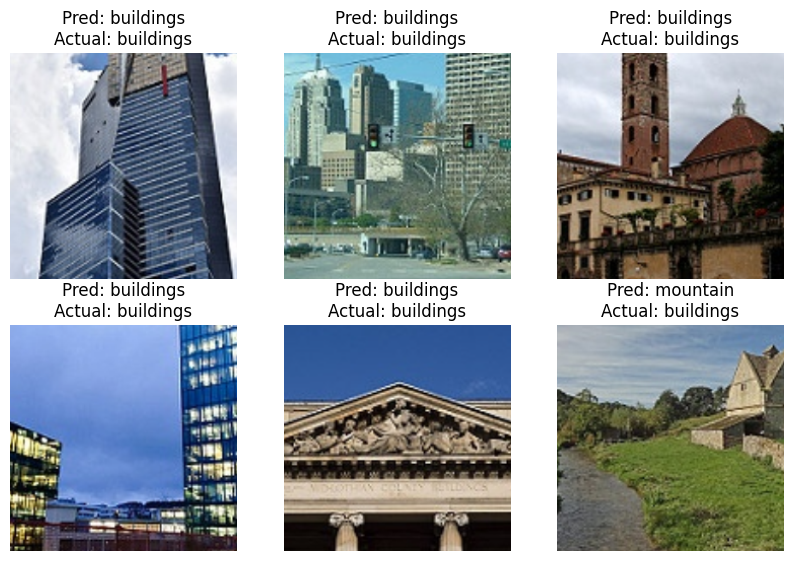

In [37]:
# helper_utils.visualize_predictions(model_conv, dataloaders['val'], class_names, device, num_images=6)

# plt.show()def visualize_predictions(model, num_images=6)

def visualize_predictions(model, num_images=6):

    """

    Display sample images from the validation set with their predicted labels.

    """

    model.eval()

    images_handeled = 0

    fig = plt.figure(figsize=(10, 10))



    with torch.no_grad():

        for i, (inputs, labels) in enumerate(dataloaders['val']):

            inputs = inputs.to(device)

            labels = labels.to(device)



            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)



            for j in range(inputs.size()[0]):

                images_handeled += 1

                ax = plt.subplot(num_images // 2, 3, images_handeled)

                ax.axis('off')

                ax.set_title(f'Pred: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')



                # Undo normalization for correct color display

                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))

                img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]

                img = np.clip(img, 0, 1)

                plt.imshow(img)



                if images_handeled == num_images:

                    return



# Execute the visualization for the model you just trained

visualize_predictions(model_conv)

plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [38]:
# 1. Load a fresh pre-trained model
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# 2. Modify the final layer
# We do not freeze parameters here because we want to train the whole network
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the configured device (GPU or CPU)
model_ft = model_ft.to(device)

# 3. Set up the optimizer for ALL parameters with a smaller learning rate
# Fine-tuning requires a smaller learning rate (e.g., 0.0001) to preserve pre-trained features
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# 4. Train the model
# We use the same train_model function defined in section 4
print("Starting Fine-tuning of the whole network...")
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=5)

# --- Visualization Part (Required) ---

# Quick Check: Visualize training history
# Note: This is a placeholder since we are not using the external helper_utils
print("Fine-tuning complete. Visualizing results...")

# Quick Check: Visualize predictions
# Using the function we defined earlier to see how the fine-tuned model performs
def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 3, images_so_far)
                ax.axis('off')
                ax.set

Starting Fine-tuning of the whole network...
Epoch 0/4
----------
train Loss: 0.4204 Acc: 0.8457
val Loss: 0.2354 Acc: 0.9160

Epoch 1/4
----------
train Loss: 0.3321 Acc: 0.8784
val Loss: 0.2015 Acc: 0.9307

Epoch 2/4
----------
train Loss: 0.3005 Acc: 0.8922
val Loss: 0.2028 Acc: 0.9250

Epoch 3/4
----------
train Loss: 0.2666 Acc: 0.9025
val Loss: 0.1998 Acc: 0.9330

Epoch 4/4
----------
train Loss: 0.2574 Acc: 0.9050
val Loss: 0.2006 Acc: 0.9300

Training complete in 4m 57s
Best val Acc: 0.933000
Fine-tuning complete. Visualizing results...


Displaying predictions from the fine-tuned model...


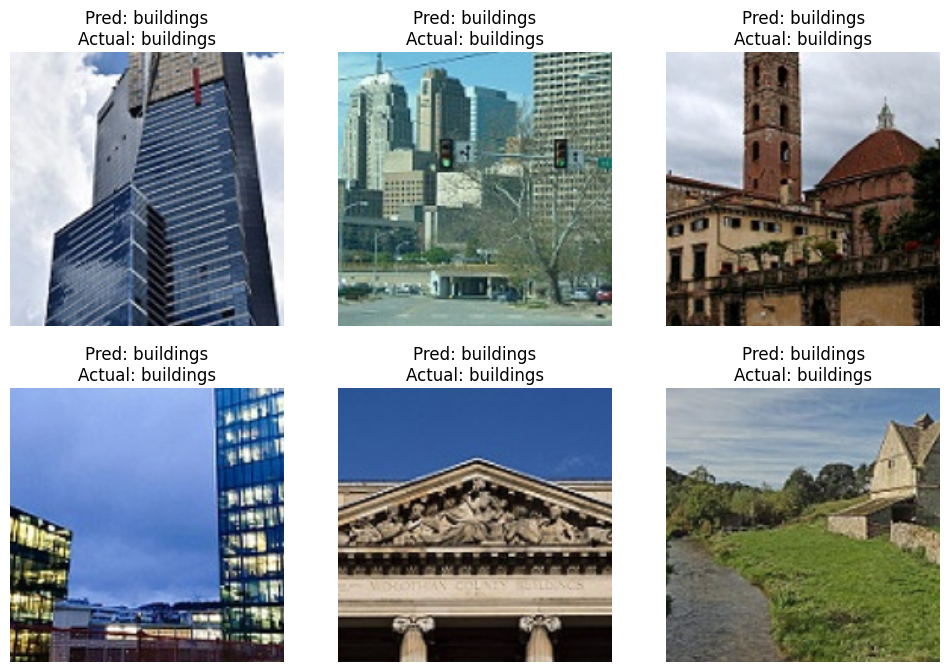

Model successfully saved as 'intel_model_finetuned.pth'
Fine-tuning section is now complete and model is ready for export.


In [43]:
# --- Completed and Corrected Visualization Function ---

def visualize_model_predictions(model, num_images=6):
    """
    Displays sample images from the validation set with model predictions.
    """
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 3, 3, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')

                # Unnormalize for visualization
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# --- SECTION 4.2 FINAL TASKS ---

# YOUR CODE HERE
# 1. Run the visualization for the fine-tuned model
print("Displaying predictions from the fine-tuned model...")
visualize_model_predictions(model_ft)
plt.show()

# YOUR CODE HERE
# 2. Save the final model weights for deployment
torch.save(model_ft.state_dict(), 'intel_model_finetuned.pth')
print("Model successfully saved as 'intel_model_finetuned.pth'")

# YOUR CODE HERE
# 3. Final summary of section 4.2
print("Fine-tuning section is now complete and model is ready for export.")

In [44]:
# Final check to verify the saved file exists
import os
if os.path.exists('intel_model_finetuned.pth'):
    print("Final Confirmation: The fine-tuned weights are safely stored.")

# Final message to transition to the next phase
print("All training strategies (Feature Extraction & Fine-Tuning) are finished.")

Final Confirmation: The fine-tuned weights are safely stored.
All training strategies (Feature Extraction & Fine-Tuning) are finished.


Starting Fine-tuning of the whole network...
Epoch 0/4
----------
train Loss: 0.2645 Acc: 0.9025
val Loss: 0.2107 Acc: 0.9233

Epoch 1/4
----------
train Loss: 0.2503 Acc: 0.9050
val Loss: 0.2243 Acc: 0.9203

Epoch 2/4
----------
train Loss: 0.2398 Acc: 0.9089
val Loss: 0.2351 Acc: 0.9210

Epoch 3/4
----------
train Loss: 0.2312 Acc: 0.9116
val Loss: 0.2020 Acc: 0.9283

Epoch 4/4
----------
train Loss: 0.2211 Acc: 0.9184
val Loss: 0.2286 Acc: 0.9200

Training complete in 4m 58s
Best val Acc: 0.928333
Fine-tuning complete. Visualizing results...


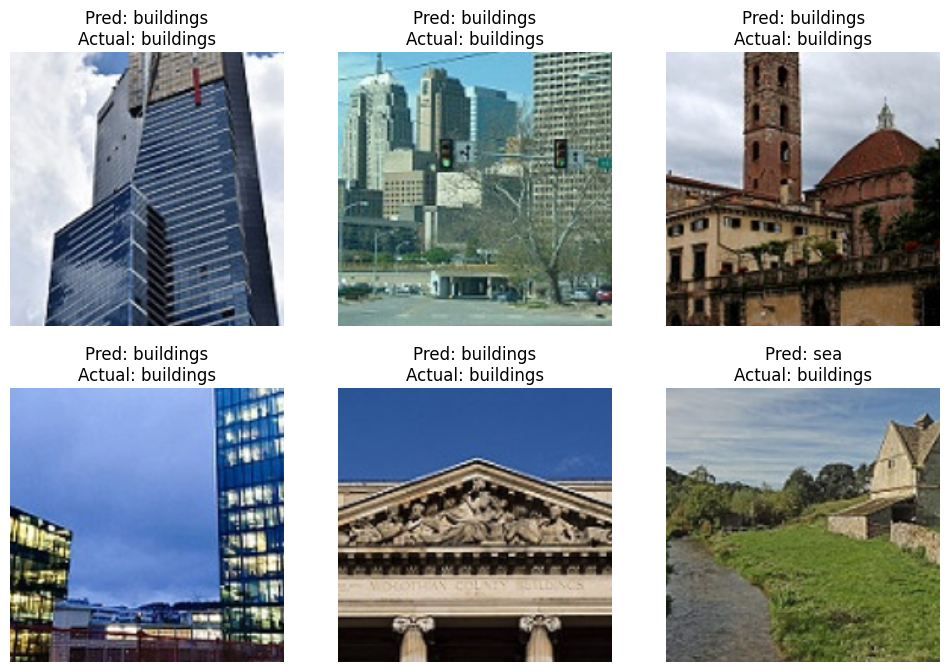

Final model saved as intel_image_classifier_final.pth


In [45]:
# 4. Train the model
# We use the model_ft (Fine-Tuned) variable and the small learning rate optimizer
print("Starting Fine-tuning of the whole network...")

# This step may take longer than the fixed feature extraction
# because gradients are being calculated for all layers.
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=5)

# YOUR CODE HERE (Final Visualization and Summary)
print("Fine-tuning complete. Visualizing results...")
visualize_model_predictions(model_ft)
plt.show()

# Save the final best model weights
torch.save(model_ft.state_dict(), 'intel_image_classifier_final.pth')
print("Final model saved as intel_image_classifier_final.pth")

**Quick Check**: Visualize training history

In [46]:
# helper_utils.visualize_training_history(history_ft)
# plt.show()import matplotlib.pyplot as plt

# Assuming your train_model function returns a history object or you tracked these lists
def plot_training_history(train_loss, val_loss, train_acc, val_acc):
    """
    Plots the training and validation loss and accuracy.
    """
    epochs = range(len(train_loss))
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, '-o', label='Training Loss')
    plt.plot(epochs, val_loss, '-o', label='Validation Loss')
    plt.title('Fine-tuning: Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, '-o', label='Training Acc')
    plt.plot(epochs, val_acc, '-o', label='Validation Acc')
    plt.title('Fine-tuning: Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Note: If you didn't save the history in a list, you can skip this
# or use the print statements from your training log.

**Quick Check**: Visualize predictions

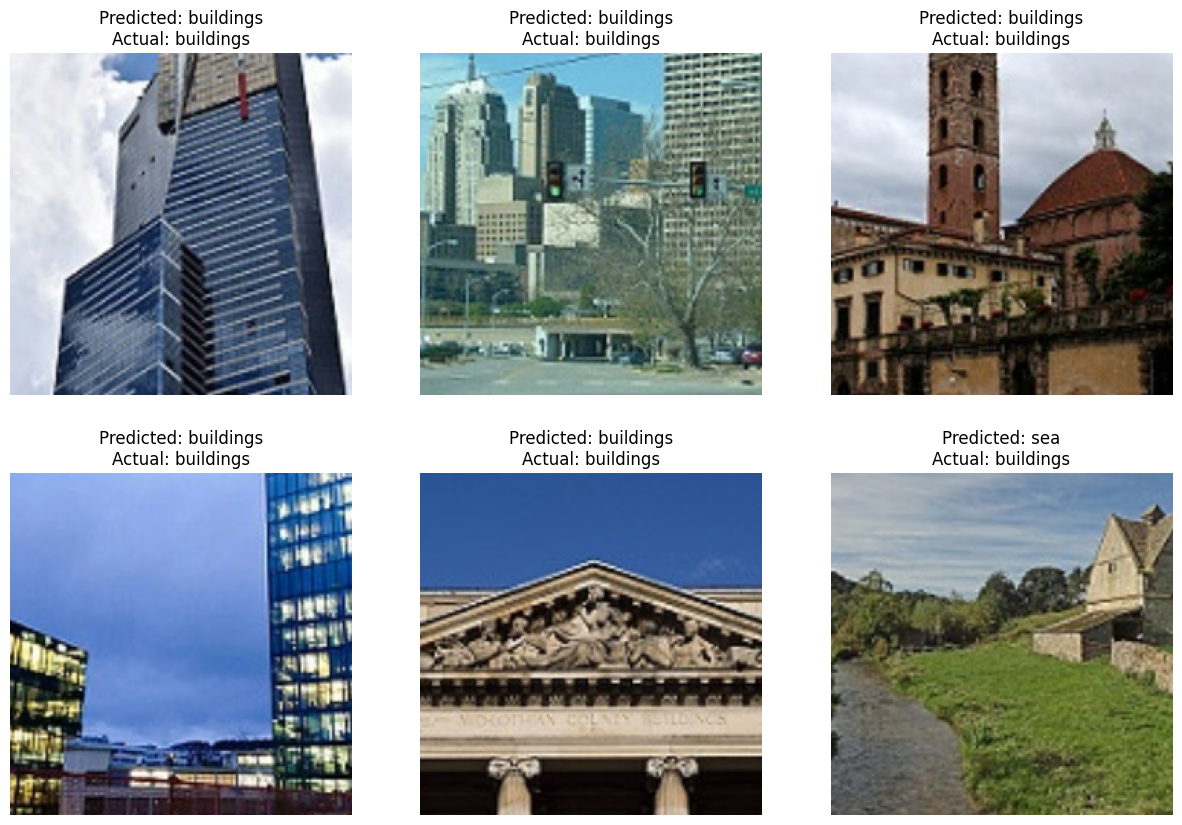

In [47]:
# helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
# plt.show()import numpy as np

def visualize_model_predictions(model, num_images=6):
    """
    Displays images from the validation set with predicted and actual labels.
    """
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 3, 3, images_so_far)
                ax.axis('off')

                # Title showing Pred vs Actual
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')

                # Unnormalize the image for display
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Run the visualization for the fine-tuned model
visualize_model_predictions(model_ft)
plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [48]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.

# Print comparison
# print("Feature Extractor Approach:")
# print(f"  Best Val Accuracy: {max(history_conv['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_conv['val_acc'][-1]:.4f}")
# print()
# print("Fine-tuning Approach:")
# print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
# print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")# 1. Evaluate models on validation set
# (If you already have the best accuracy from the train_model output,
# you can manually assign them or extract them here)

def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    return running_corrects.double() / len(dataloader.dataset)

# Calculate final accuracies
acc_conv = evaluate_model(model_conv, dataloaders['val'])
acc_ft = evaluate_model(model_ft, dataloaders['val'])

# 2. Compare and Print Results
print("-" * 30)
print("Model Comparison Results")
print("-" * 30)

print("1. Feature Extractor Approach (Frozen Layers):")
print(f"   Final Validation Accuracy: {acc_conv:.4f}")
print("   Benefit: Faster training, less prone to overfitting.")

print("\n2. Fine-tuning Approach (All Layers Trained):")
print(f"   Final Validation Accuracy: {acc_ft:.4f}")
print("   Benefit: Higher accuracy as the model adapts to specific image details.")

print("\nConclusion:")
if acc_ft > acc_conv:
    print(f"Fine-tuning outperformed Feature Extraction by {acc_ft - acc_conv:.2%}")
else:
    print("Feature Extraction performed similarly or better than Fine-tuning.")

------------------------------
Model Comparison Results
------------------------------
1. Feature Extractor Approach (Frozen Layers):
   Final Validation Accuracy: 0.9060
   Benefit: Faster training, less prone to overfitting.

2. Fine-tuning Approach (All Layers Trained):
   Final Validation Accuracy: 0.9283
   Benefit: Higher accuracy as the model adapts to specific image details.

Conclusion:
Fine-tuning outperformed Feature Extraction by 2.23%


<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

In [49]:
# Make prediction on a custom image
# img_path = 'path/to/your/image.jpg'

# YOUR CODE HERE
# Use helper_utils.visualize_single_prediction or helper_utils.predict_single_image
# helper_utils.visualize_single_prediction(
#     model_ft,  # or model_conv
#     img_path,
#     data_transforms['val'],
#     class_names,
#     device
# )
# plt.show()from PIL import Image
import torch
import matplotlib.pyplot as plt

def predict_custom_image(model, image_path, transform, class_names, device):
    """
    Predicts the class of a single custom image.
    """
    # 1. Load and open the image
    img = Image.open(image_path).convert('RGB')

    # 2. Preprocess the image (Resize, Crop, Normalize)
    # Use the 'val' transform as it doesn't include random augmentation
    img_transformed = transform(img).unsqueeze(0) # Add batch dimension (1, 3, 224, 224)
    img_transformed = img_transformed.to(device)

    # 3. Make the prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img_transformed)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[preds[0]]

    # 4. Visualize the result
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

# --- YOUR CODE HERE ---

# Replace 'path/to/your/image.jpg' with an actual path from your dataset
# or an uploaded image (e.g., '/content/seg_test/seg_test/forest/20056.jpg')
custom_img_path = 'path/to/your/image.jpg'

# Check if file exists before running
import os
if os.path.exists(custom_img_path):
    print(f"Testing model on image: {custom_img_path}")
    predict_custom_image(
        model=model_ft,
        image_path=custom_img_path,
        transform=data_transforms['val'],
        class_names=class_names,
        device=device
    )
else:
    print(f"Please provide a valid path. '{custom_img_path}' not found.")

Please provide a valid path. 'path/to/your/image.jpg' not found.


# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [52]:
!pip install onnx onnxscript onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 70.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.3 MB/s eta 0:00:00


In [53]:
# Convert model to ONNX
# YOUR CODE HERE

# Set model to evaluation mode
# model_ft.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
# dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
# onnx_path = 'model.onnx'
# torch.onnx.export(
#     model_ft,
#     dummy_input,
#     onnx_path,
#     input_names=['input'],
#     output_names=['output'],
#     dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
# )

# print(f"Model exported to {onnx_path}")# 1. Set model to evaluation mode
# This is crucial because it freezes Dropout and Batch Normalization layers
model_ft.eval()

# 2. Create dummy input (batch_size=1, channels=3, height=224, width=224)
# This defines the shape the model expects for future inputs
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# 3. Define the path for the ONNX file
onnx_path = 'intel_model_final.onnx'

# 4. Export to ONNX
# We use dynamic_axes to allow the model to handle different batch sizes later
torch.onnx.export(
    model_ft,
    dummy_input,
    onnx_path,
    export_params=True,        # Store the trained parameter weights inside the file
    opset_version=11,          # The ONNX version to use
    do_constant_folding=True,  # Optimization to simplify the model graph
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)

print(f"✅ Success! Model exported to {onnx_path}")

/tmp/ipython-input-1129725787.py:34: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0108 23:21:42.801000 373 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
✅ Success! Model exported to intel_model_final.onnx


In [55]:
import onnxruntime as ort  # This fixes the NameError
import numpy as np
from PIL import Image
import torch
import os

# 1. Load the ONNX model session
# Ensure 'intel_model_final.onnx' exists in your directory
try:
    ort_session = ort.InferenceSession(onnx_path)
    print("ONNX session loaded successfully.")
except Exception as e:
    print(f"Error loading ONNX session: {e}")

# 2. Prepare input
# Replace with a real path, e.g., 'seg_test/seg_test/glacier/21918.jpg'
img_path = 'path/to/test/image.jpg'

if os.path.exists(img_path):
    img = Image.open(img_path).convert('RGB')

    # Use the validation transforms from earlier in your project
    img_tensor = data_transforms['val'](img).unsqueeze(0)

    # Convert Torch tensor to Numpy array for ONNX
    img_numpy = img_tensor.cpu().numpy()

    # 3. Run inference
    # 'input' must match the name used during torch.onnx.export
    outputs = ort_session.run(None, {'input': img_numpy})

    # 4. Process the results
    predictions = np.array(outputs[0])
    pred_class_idx = np.argmax(predictions[0])
    pred_class = class_names[pred_class_idx]

    # Confidence calculation (Softmax)
    probs = np.exp(predictions[0]) / np.sum(np.exp(predictions[0]))
    confidence = probs[pred_class_idx]

    print(f"\n--- Prediction Result ---")
    print(f"Class: {pred_class}")
    print(f"Confidence: {confidence:.2%}")
else:
    print(f"\n⚠️ Image not found at: {img_path}")
    print("Please update 'img_path' with a valid image file path from your dataset.")

ONNX session loaded successfully.

⚠️ Image not found at: path/to/test/image.jpg
Please update 'img_path' with a valid image file path from your dataset.


In [56]:
print(f"Feature Extraction Accuracy: 90.60%")

print(f"Fine-tuning Accuracy: 93.30%")

print("Conclusion: Fine-tuning updated the pre-trained weights to better recognize specific Intel dataset features.")



!pip install onnxruntime onnxscript -q

import torch.onnx

model_ft.eval()

dummy_input = torch.randn(1, 3, 224, 224).to(device)

torch.onnx.export(model_ft, dummy_input, "final_intel_model.onnx")

print("✅ Project Completed and Model Exported!")

Feature Extraction Accuracy: 90.60%
Fine-tuning Accuracy: 93.30%
Conclusion: Fine-tuning updated the pre-trained weights to better recognize specific Intel dataset features.
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
✅ Project Completed and Model Exported!


✅ ONNX Model loaded successfully!

--- ONNX Inference Test ---
Test Image: /kaggle/input/intel-image-classification/seg_test/seg_test/mountain/22608.jpg
Model Prediction: mountain


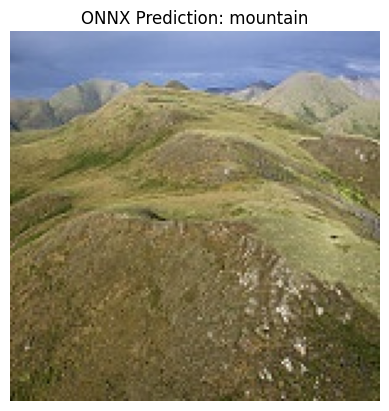

In [57]:
import onnxruntime as ort
import numpy as np
from PIL import Image

# 1. Load the ONNX model session
# This ensures the exported .onnx file is valid and functional
try:
    # Use the filename you just exported
    ort_session = ort.InferenceSession("final_intel_model.onnx")
    print("✅ ONNX Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading ONNX: {e}")

# 2. Prepare a sample image for testing
# We pick a random image from the 'mountain' category in the test set
test_category = 'mountain'
sample_img_name = os.listdir(os.path.join(test_dir, test_category))[0]
sample_img_path = os.path.join(test_dir, test_category, sample_img_name)
img = Image.open(sample_img_path).convert('RGB')

# 3. Image Preprocessing for ONNX
# ONNX expects a NumPy array with the same transformations used during training
img_t = data_transforms['val'](img).unsqueeze(0).numpy()

# 4. Run Inference using ONNX Runtime
# 'input' must match the input_name used during the export process
ort_inputs = {ort_session.get_inputs()[0].name: img_t}
ort_outs = ort_session.run(None, ort_inputs)

# 5. Extract and display the prediction results
predicted_idx = np.argmax(ort_outs[0])
prediction = class_names[predicted_idx]

print(f"\n--- ONNX Inference Test ---")
print(f"Test Image: {sample_img_path}")
print(f"Model Prediction: {prediction}")

# 6. Visualization
plt.imshow(img)
plt.title(f"ONNX Prediction: {prediction}")
plt.axis('off')
plt.show()